In [112]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import numpy.linalg as npl
import numpy.random as npr


import scipy.linalg as la


from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

import cvxpy as cp
from cvxpylayers.torch import CvxpyLayer

import matplotlib.pyplot as plt

import pandas as pd

from pathlib import Path  

import sys
import time
output_stream = sys.stdout

import gurobipy as gp
from gurobipy import GRB

import time
colors = ["tab:blue", "tab:orange", "tab:green",
          "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:grey", "tab:olive","tab:blue", "tab:orange", "tab:green",
          "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:grey", "tab:olive"] 

In [113]:
x_sols = np.load("x_sols.npy") 
Opt_vals = np.load("Opt_vals.npy")
eval_vals = np.load("eval_vals.npy")
probs= np.load("probs.npy")
setuptimes = np.load("setuptimes.npy")
solvetimes = np.load("solvetimes.npy")

In [114]:
#K_nums = np.array([1,5,50,100,300])
np.array([1,10,20,50,100,500,1000]) # different cluster values we consider
K_tot = K_nums.size  # Total number of clusters we consider
N_tot = 300
M = 10
R = 10           # Total times we repeat experiment to estimate final probabilty
m = 50 
eps_min = -5    # minimum epsilon we consider
eps_max = -3.9       # maximum epsilon we consider
eps_nums = np.linspace(eps_min,eps_max,M)
eps_nums = 10**(eps_nums)
eps_tot = M

In [115]:
Opt_vals = Opt_vals/10
eval_vals = eval_vals/10

In [110]:
xcount = np.zeros((K_tot, eps_tot,R))
for r in range(R):
    for K in range(K_tot):
        for eps in range(eps_tot):
            xcount[K,eps,r] = sum(x_sols[K,eps,:,r] > 0.001)

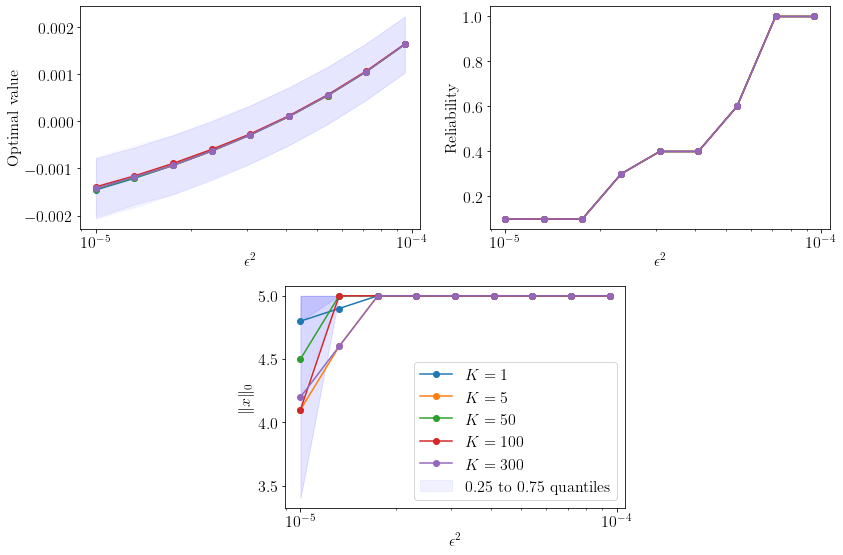

In [111]:
plt.rcParams.update({
    "text.usetex": True,
    "font.size": 16,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    "font.family" : "serif"

})
import matplotlib.gridspec as gridspec

#fig, (ax1, ax2,ax3) = plt.subplots(1, 2, figsize=(12, 8))
plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(4, 4)

ax1 = plt.subplot(gs[:2, :2])
ax2 = plt.subplot(gs[:2, 2:])
ax3 = plt.subplot(gs[2:4, 1:3])

labelprint = 1
for K_count, K in enumerate(K_nums):
    if labelprint== 1:
        ax1.fill_between(eps_nums[:-1], np.quantile(Opt_vals[:,:-1,:],0.25,axis = 2)[K_count,:], np.quantile(Opt_vals[:,:-1,:],0.75,axis = 2)[K_count,:], color = "blue", alpha = 0.02, label = "0.25 to 0.75 quantiles")
    else: 
        ax1.fill_between(eps_nums[:-1], np.quantile(Opt_vals[:,:-1,:],0.25,axis = 2)[K_count,:], np.quantile(Opt_vals[:,:-1,:],0.75,axis = 2)[K_count,:], color = "blue", alpha = 0.02)
    labelprint = 0
    ax1.plot(eps_nums[:-1], np.mean(Opt_vals[:,:-1,:],axis = 2)[K_count,:],linestyle='-', marker='o', color = colors[K_count], label = "$K = {}$".format(round(K,4)))
ax1.set_xlabel("$\epsilon^2$")
ax1.set_xscale("log")
ax1.set_ylabel("Optimal value")
#plt.legend(fontsize=7.5)
#plt.savefig("portMIPoptimalvalue.pdf")
#plt.show()

for K_count, K in enumerate(K_nums):
    ax2.plot(eps_nums[:-1], np.mean(probs[:,:-1,:],axis = 2)[K_count,:],linestyle='-', marker='o', color = colors[K_count], label = "$K = {}$".format(round(K,4)))
ax2.set_xlabel("$\epsilon^2$")
ax2.set_xscale("log")
ax2.set_ylabel("Reliability")
#ax2.legend()
#plt.savefig("portMIPreliability.pdf")
#plt.show()


#plt.figure(figsize=(6, 4))
labelprint = 1

for K_count, K in enumerate(K_nums):
    if labelprint== 1:
        ax3.fill_between(eps_nums[:-1], np.quantile(xcount[K_count,:-1,:],0.2,axis=1), np.quantile(xcount[K_count,:-1],0.8,axis=1), color = "blue", alpha = 0.05, label = "0.25 to 0.75 quantiles")
    else:
        ax3.fill_between(eps_nums[:-1], np.quantile(xcount[K_count,:-1,:],0.2,axis=1), np.quantile(xcount[K_count,:-1],0.8,axis=1), color = "blue", alpha = 0.05)
    labelprint = 0
    ax3.plot(eps_nums[:-1], np.mean(xcount[K_count,:-1,:],axis = 1), linestyle='-', marker='o', label = "$K = {}$".format(round(K,4)))
ax3.legend(loc = "lower right")
ax3.set_xlabel("$\epsilon^2$")
ax3.set_xscale("log")
ax3.set_ylabel("$\|x\|_0$")
plt.tight_layout()
#plt.title("Cardinality of portfolio vs. level of conservatism")
plt.savefig("portMIPtop.pdf")
#plt.show()


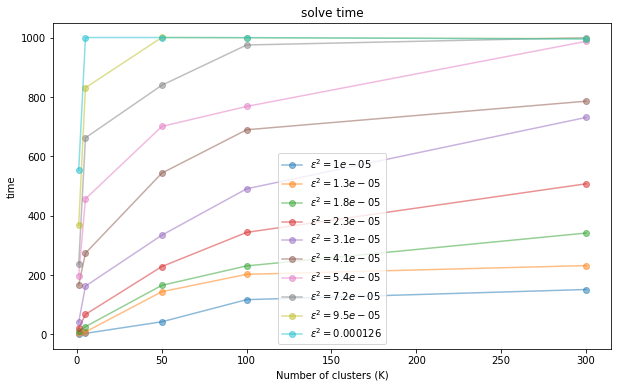

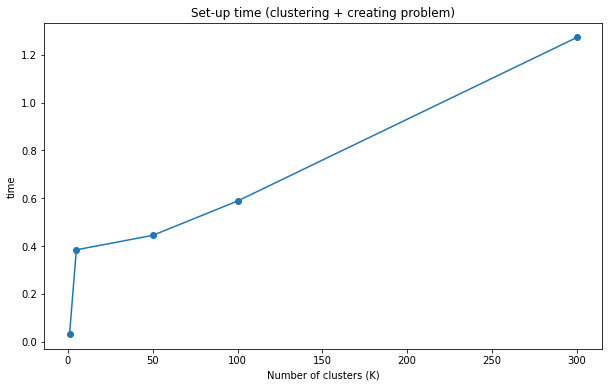

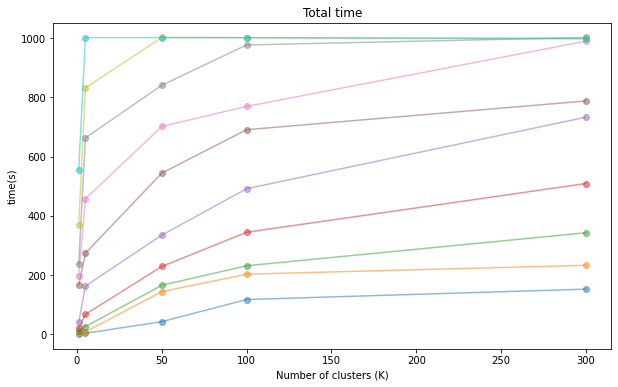

In [36]:
plt.figure(figsize=(10, 6))
for eps_count, eps in enumerate(eps_nums):
    plt.plot(K_nums,np.mean(solvetimes[:,:,:],axis = 2)[:,eps_count],linestyle='-', marker='o', label = "$\epsilon^2 = {}$".format(round(eps,6)), alpha = 0.5)
    plt.xlabel("Number of clusters (K)")

plt.ylabel("time")
plt.title("solve time")
#plt.yscale("log")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(K_nums,np.mean(setuptimes,axis = 1),linestyle='-', marker='o')
plt.xlabel("Number of clusters (K)")
plt.ylabel("time")
plt.title("Set-up time (clustering + creating problem)")
plt.show()

plt.figure(figsize=(10, 6))
for eps_count, eps in enumerate(eps_nums):
    plt.plot(K_nums[:],np.mean(setuptimes[:,:],axis = 1) + np.mean(solvetimes[:,:,:],axis = 2)[:,eps_count],linestyle='-', marker='o', label = "$\epsilon^2 = {}$".format(round(eps,6)), alpha = 0.5)
    plt.xlabel("Number of clusters (K)")

plt.ylabel("time(s)")
plt.title("Total time")
#plt.yscale("log")
#plt.legend(fontsize=6)
plt.show()

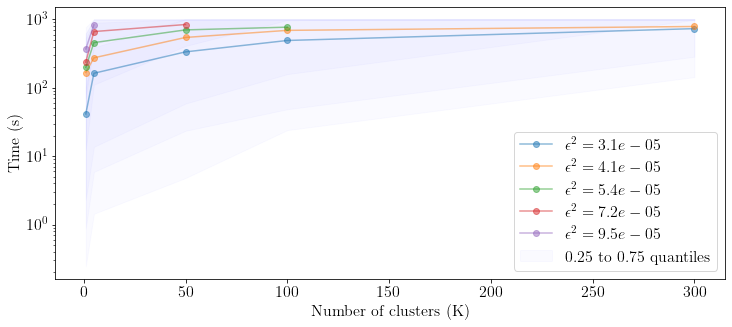

In [116]:
plt.figure(figsize=(12, 5))
start = 3
labelprint = 1
for eps_count in [4,5,6,7,8]:
    if labelprint== 1:
        plt.fill_between(K_nums[:],np.quantile(solvetimes[:,:,:],0.1,axis = 2)[:,eps_count], np.quantile(solvetimes[:,:,:],0.9,axis = 2)[:,eps_count], color = "b", alpha = 0.02, label = "0.25 to 0.75 quantiles")
        labelprint = 0
    else:
        plt.fill_between(K_nums[:],np.quantile(solvetimes[:,:,:],0.1,axis = 2)[:,eps_count], np.quantile(solvetimes[:,:,:],0.9,axis = 2)[:,eps_count], color = "b", alpha = 0.02)
plt.plot(K_nums[:], np.mean(solvetimes[:,:,:],axis = 2)[:,4],linestyle='-', marker='o', label = "$\epsilon^2 = {}$".format(round(eps_nums[4],6)), alpha = 0.5)
plt.plot(K_nums[:], np.mean(solvetimes[:,:,:],axis = 2)[:,5],linestyle='-', marker='o', label = "$\epsilon^2 = {}$".format(round(eps_nums[5],6)), alpha = 0.5)
plt.plot(K_nums[:4], np.mean(solvetimes[:4,:,:],axis = 2)[:,6],linestyle='-', marker='o', label = "$\epsilon^2 = {}$".format(round(eps_nums[6],6)), alpha = 0.5)
plt.plot(K_nums[:3], np.mean(solvetimes[:3,:,:],axis = 2)[:,7],linestyle='-', marker='o', label = "$\epsilon^2 = {}$".format(round(eps_nums[7],6)), alpha = 0.5)
plt.plot(K_nums[:2], np.mean(solvetimes[:2,:,:],axis = 2)[:,8],linestyle='-', marker='o', label = "$\epsilon^2 = {}$".format(round(eps_nums[8],6)), alpha = 0.5)

plt.xlabel("Number of clusters (K)")
plt.ylabel("Time (s)")
#plt.title("Total time")
plt.yscale("log")
plt.legend(loc = "lower right")
plt.savefig("portMIPtotaltime.pdf")
plt.show()


In [99]:
np.mean(solvetimes[:,:,:],axis = 2)[:,8]

array([ 368.36530533,  831.71625643, 1001.22795348, 1000.13309462,
        997.36177483])

In [82]:
np.mean(solvetimes[:,:,:],axis = 2)[:,5]

array([166.97605259, 273.89268343, 543.77274213, 690.04105828,
       786.31344085])

In [14]:
eps_min = -6    # minimum epsilon we consider
eps_max = -4.2      # maximum epsilon we consider
eps_nums = np.linspace(eps_min,eps_max,10)
eps_nums = 10**(eps_nums)
eps_tot = 10

In [149]:
eps_nums

array([1.00000000e-06, 1.58489319e-06, 2.51188643e-06, 3.98107171e-06,
       6.30957344e-06, 1.00000000e-05, 1.58489319e-05, 2.51188643e-05,
       3.98107171e-05, 6.30957344e-05])